<a href="https://colab.research.google.com/github/Aliisaev00/DLAI-project/blob/main/DLAI_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VQ-VAE a posteriori with Geodesic Quantization

## Downloading all needed pips & preparing the environment

In [2]:
!pip install -q torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121
!pip install -q scikit-learn scipy tqdm umap-learn networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.1 MB/s eta 0:00:00


1. Basic VAE on MNIST

In [3]:
import torch, torch.nn as nn, torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# Hyperparameters
LATENT_DIM = 16
BATCH_SIZE = 128
EPOCHS = 5      # since 5 epochs is enough for baseline
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Data
transform = transforms.ToTensor()
train_ds = datasets.MNIST(root='.', train=True , download=True, transform=transform)
test_ds  = datasets.MNIST(root='.', train=False, download=True, transform=transform)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dl  = DataLoader(test_ds , batch_size=BATCH_SIZE, shuffle=False)

# VAE
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc_mu = nn.Linear(256, LATENT_DIM)
        self.fc_logvar = nn.Linear(256, LATENT_DIM)
    def forward(self, x):
        x = x.view(len(x), -1)
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(LATENT_DIM, 256)
        self.out = nn.Linear(256, 28*28)
    def forward(self, z):
        h = F.relu(self.fc(z))
        return torch.sigmoid(self.out(h)).view(-1,1,28,28)

class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc, self.dec = Encoder(), Decoder()
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    def forward(self, x):
        mu, logvar = self.enc(x)
        z  = self.reparameterize(mu, logvar)
        return self.dec(z), mu, logvar

vae = VAE().to(DEVICE)
opt = torch.optim.Adam(vae.parameters(), lr=1e-3)

# Training
for epoch in range(EPOCHS):
    vae.train()
    total = 0
    for x,_ in tqdm(train_dl, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        x = x.to(DEVICE)
        recon, mu, logvar = vae(x)
        recon_loss = F.binary_cross_entropy(recon, x, reduction='sum')
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + kl
        opt.zero_grad(); loss.backward(); opt.step()
        total += loss.item()
    print(f"  ➜ train ELBO: {total/len(train_ds):.2f}")

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.49MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.94MB/s]
Epoch 1/5: 100%|██████████| 468/468 [00:14<00:00, 33.15it/s]


  ➜ train ELBO: 172.09


Epoch 2/5: 100%|██████████| 468/468 [00:14<00:00, 31.32it/s]


  ➜ train ELBO: 126.40


Epoch 3/5: 100%|██████████| 468/468 [00:14<00:00, 33.34it/s]


  ➜ train ELBO: 118.55


Epoch 4/5: 100%|██████████| 468/468 [00:14<00:00, 32.92it/s]


  ➜ train ELBO: 115.08


Epoch 5/5: 100%|██████████| 468/468 [00:14<00:00, 31.78it/s]

  ➜ train ELBO: 112.97


2. Extracting latents and building baseline clustering

In [4]:
import numpy as np
from sklearn.cluster import KMeans

vae.eval()
latents = []
with torch.no_grad():
    for x,_ in DataLoader(train_ds, batch_size=512):
        mu,_ = vae.enc(x.to(DEVICE))
        latents.append(mu.cpu())
latents = torch.cat(latents).numpy()      # shape: (60000, LATENT_DIM)

k = 256                                   # codebook size
kmeans_euc = KMeans(n_clusters=k, n_init=10, random_state=0).fit(latents)
codes_euc  = kmeans_euc.labels_

3. Euclidean K‑Means baseline

In [5]:
from sklearn.cluster import KMeans

k = 256                                # same k everywhere
kmeans_euc = KMeans(n_clusters=k, n_init=10, random_state=0).fit(latents)

codes_euc      = kmeans_euc.labels_            # length 60 000
codebook_euc   = kmeans_euc.cluster_centers_   # (256, LATENT_DIM)

4. Geodesic clustering (MDS + KMeans)
(first K-medoids was tried)

In [ ]:
# from sklearn.neighbors import NearestNeighbors
# from scipy.sparse.csgraph import shortest_path
# from sklearn_extra.cluster import KMedoids

# # 3.1 k‑NN‑graph
# knn = NearestNeighbors(n_neighbors=15, metric='euclidean').fit(latents)
# adj = knn.kneighbors_graph(mode='distance')

# # 3.2 All‑Pairs Shortest Path
# geo_dist = shortest_path(adj, directed=False)

# # 3.3 K‑Medoids with "precomputed" metric
# kmed = KMedoids(n_clusters=k, metric='precomputed', init='random', random_state=0).fit(geo_dist)
# codes_geo = kmed.labels_

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
# !pip uninstall -y scikit-learn-extra

Found existing installation: scikit-learn-extra 0.3.0.dev0
Uninstalling scikit-learn-extra-0.3.0.dev0:
  Successfully uninstalled scikit-learn-extra-0.3.0.dev0


In [ ]:
# !pip install -q --upgrade pip setuptools wheel cython pybind11>=2.12

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


In [ ]:
# from sklearn_extra.cluster import KMedoids


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

ImportError: numpy.core.multiarray failed to import (auto-generated because you didn't call 'numpy.import_array()' after cimporting numpy; use '<void>numpy._import_array' to disable if you are certain you don't need it).

In [22]:
from sklearn.manifold import Isomap

# 1) Isomap fit on subsample
M = 10_000                                # subsample size
idx_sub = np.random.choice(len(latents), M, replace=False)
lat_sub = latents[idx_sub]

isomap = Isomap(n_neighbors=15,
                n_components=LATENT_DIM,
                n_jobs=-1)
latent_iso_sub = isomap.fit_transform(lat_sub)   # shape (M, 16)

# 2) K-Means in the Isomap space (same subsample)
k = 256
kmeans_geo = KMeans(n_clusters=k,
                    n_init=10,
                    random_state=0).fit(latent_iso_sub)
codebook_geo = kmeans_geo.cluster_centers_       # (256, 16)

# 3) Assign a code to every latent vector

BATCH = 10_000             # chunk-size to save RAM
codes_full = np.empty(len(latents), dtype=np.int32)

for start in range(0, len(latents), BATCH):
    stop   = min(start + BATCH, len(latents))
    chunk  = latents[start:stop]

    # Embed the chunk in the same Isomap space
    iso_chunk = isomap.transform(chunk)

    # Predict nearest centroid index
    codes_full[start:stop] = kmeans_geo.predict(iso_chunk)

5. Instantiate the two decoders

In [23]:
class CodeDecoder(nn.Module):
    def __init__(self, codebook):
        super().__init__()
        self.codebook = nn.Parameter(
            torch.tensor(codebook, dtype=torch.float32), requires_grad=False
        )
        self.fc  = nn.Linear(LATENT_DIM, 256)
        self.out = nn.Linear(256, 28 * 28)

    def forward(self, idx):
        z = self.codebook[idx]            # (B, LATENT_DIM)
        h = F.relu(self.fc(z))
        return torch.sigmoid(self.out(h)).view(-1, 1, 28, 28)

dec_euc = CodeDecoder(codebook_euc).to(DEVICE)
dec_geo = CodeDecoder(codebook_geo).to(DEVICE)

6. Dataset that returns both code indices

In [24]:
from torch.utils.data import Dataset, DataLoader

class CodeDataset(Dataset):
    def __init__(self, base_ds, codes_euc, codes_geo):
        self.base_ds   = base_ds
        self.codes_euc = codes_euc
        self.codes_geo = codes_geo
    def __len__(self):  return len(self.base_ds)
    def __getitem__(self, idx):
        img, _ = self.base_ds[idx]
        return img, self.codes_euc[idx], self.codes_geo[idx]

code_ds = CodeDataset(train_ds, codes_euc, codes_full)
code_dl = DataLoader(code_ds, batch_size=BATCH_SIZE,
                     shuffle=True, drop_last=True)

7. Fine‑tune both decoders

In [25]:
def finetune_decoder(decoder, code_selector, name):
    decoder.train()
    opt = torch.optim.Adam(decoder.parameters(), lr=1e-3)
    for epoch in range(5):
        total = 0
        for imgs, idx_euc, idx_geo in code_dl:
            idx = code_selector(idx_euc, idx_geo).to(DEVICE)  # choose Euclidean or Geodesic
            imgs = imgs.to(DEVICE)
            recon = decoder(idx)
            loss  = F.binary_cross_entropy(recon, imgs, reduction='mean')
            opt.zero_grad(); loss.backward(); opt.step()
            total += loss.item()
        print(f"{name}  epoch {epoch+1}/5  BCE={total/len(code_dl):.4f}")

finetune_decoder(dec_euc, lambda e, g: e, "Euclidean")
finetune_decoder(dec_geo, lambda e, g: g, "Geodesic")

Euclidean  epoch 1/5  BCE=0.2018
Euclidean  epoch 2/5  BCE=0.1648
Euclidean  epoch 3/5  BCE=0.1632
Euclidean  epoch 4/5  BCE=0.1625
Euclidean  epoch 5/5  BCE=0.1622
Geodesic  epoch 1/5  BCE=0.1912
Geodesic  epoch 2/5  BCE=0.1683
Geodesic  epoch 3/5  BCE=0.1671
Geodesic  epoch 4/5  BCE=0.1665
Geodesic  epoch 5/5  BCE=0.1661


8. Evaluate reconstruction loss

In [26]:
def recon_error(decoder, codes, subset=10000):
    idx = np.random.choice(len(train_ds), subset, replace=False)
    imgs = torch.stack([train_ds[i][0] for i in idx]).to(DEVICE)
    decoder.eval()
    with torch.no_grad():
        recon = decoder(torch.tensor(codes[idx], device=DEVICE))
        return F.binary_cross_entropy(recon, imgs, reduction='mean').item()

err_euc = recon_error(dec_euc, codes_euc)
err_geo = recon_error(dec_geo, codes_full)
print(f"Final BCE  • Euclidean: {err_euc:.4f}  • Geodesic: {err_geo:.4f}")

Final BCE  • Euclidean: 0.1614  • Geodesic: 0.1660


Graphs

In [14]:
!pip -q install umap-learn

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(np.float64(-3.6815726161003113),
 np.float64(12.657775819301605),
 np.float64(-2.6281248569488525),
 np.float64(13.478603029251099))

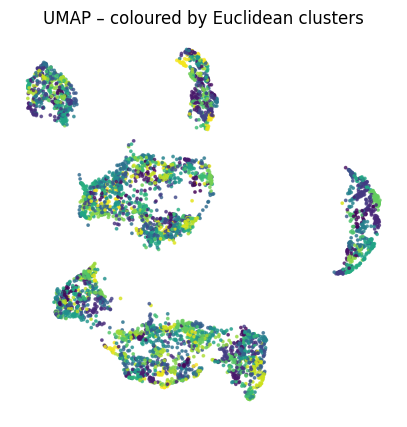

In [27]:
# UMAP projection of the latent space
import umap
import matplotlib.pyplot as plt

SUBSET = 5000
idx    = np.random.choice(len(latents), SUBSET, replace=False)
latent_sample   = latents[idx]
codes_euc_sample = codes_euc[idx]
codes_geo_sample = codes_full[idx]

proj = umap.UMAP(n_components=2, random_state=0).fit_transform(latent_sample)

# Euclidean colouring
plt.figure(figsize=(5,5))
plt.scatter(proj[:,0], proj[:,1], s=3, c=codes_euc_sample, alpha=0.7)
plt.title("UMAP – coloured by Euclidean clusters")
plt.axis('off')

(np.float64(-3.6815726161003113),
 np.float64(12.657775819301605),
 np.float64(-2.6281248569488525),
 np.float64(13.478603029251099))

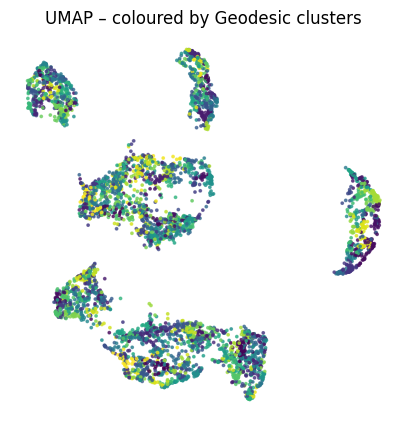

In [28]:
# Geodesic colouring
plt.figure(figsize=(5,5))
plt.scatter(proj[:,0], proj[:,1], s=3, c=codes_geo_sample, alpha=0.7)
plt.title("UMAP – coloured by Geodesic clusters")
plt.axis('off')

Text(0.5, 1.0, 'Final reconstruction loss')

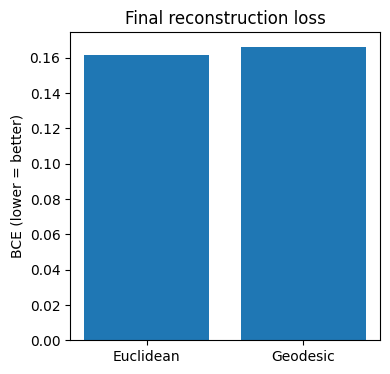

In [29]:
# Bar chart of reconstruction loss
plt.figure(figsize=(4,4))
plt.bar(['Euclidean', 'Geodesic'], [err_euc, err_geo])
plt.ylabel("BCE (lower = better)")
plt.title("Final reconstruction loss")

In [30]:
# Cluster‑usage statistics

used_euc = np.unique(codes_euc)
used_geo = np.unique(codes_full)

util_euc = len(used_euc) / 256
util_geo = len(used_geo) / 256

sizes_euc = np.bincount(codes_euc, minlength=256)
sizes_geo = np.bincount(codes_full, minlength=256)

std_euc = sizes_euc.std()
std_geo = sizes_geo.std()

print(f"Used codes – Euclidean: {len(used_euc)} / 256  ({util_euc:.1%})")
print(f"Used codes – Geodesic:  {len(used_geo)} / 256  ({util_geo:.1%})")
print(f"Cluster std‑dev – Euclidean: {std_euc:.2f}")
print(f"Cluster std‑dev – Geodesic:  {std_geo:.2f}")

Used codes – Euclidean: 256 / 256  (100.0%)
Used codes – Geodesic:  256 / 256  (100.0%)
Cluster std‑dev – Euclidean: 71.19
Cluster std‑dev – Geodesic:  100.06


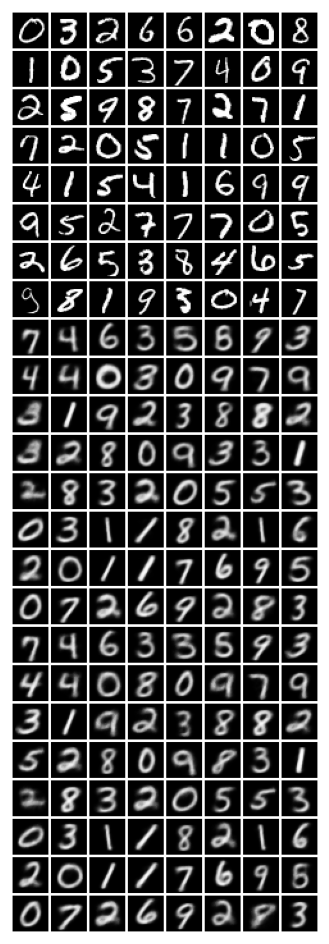

In [32]:
# Reconstruction grid: original | Euclid | Geodesic

import torch, numpy as np, torchvision.utils as vutils, matplotlib.pyplot as plt

GRID_N = 8                           # 8×8 originals = 64 samples
idx = np.random.choice(len(test_ds), GRID_N**2, replace=False)
imgs = torch.stack([test_ds[i][0] for i in idx]).to(DEVICE)

# Decode with both codebooks
with torch.no_grad():
    recon_e = dec_euc(torch.tensor(codes_euc[idx], device=DEVICE))
    recon_g = dec_geo(torch.tensor(codes_full[idx], device=DEVICE))

# Stack: originals (top), Euclidean recon (middle), Geodesic recon (bottom)
grid_tensor = torch.cat([imgs.cpu(), recon_e.cpu(), recon_g.cpu()])
grid = vutils.make_grid(grid_tensor, nrow=GRID_N, pad_value=1.0)

plt.figure(figsize=(8, 12))
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()